In [1]:
!ls '/kaggle/input/image-classification-for-plants-leaf/Train images'

0.jpg	  1601.xml  2203.jpg  2840.xml	3425.jpg  4058.xml  4679.jpg  5295.xml
0.xml	  1605.jpg  2203.xml  2842.jpg	3425.xml  4059.jpg  4679.xml  5296.jpg
1001.jpg  1605.xml  2205.jpg  2842.xml	3427.jpg  4059.xml  467.jpg   5296.xml
1001.xml  1606.jpg  2205.xml  2843.jpg	3427.xml  405.jpg   467.xml   5297.jpg
1005.jpg  1606.xml  2206.jpg  2843.xml	3429.jpg  405.xml   4680.jpg  5297.xml
1005.xml  1608.jpg  2206.xml  2844.jpg	3429.xml  4061.jpg  4680.xml  5298.jpg
1006.jpg  1608.xml  2207.jpg  2844.xml	342.jpg   4061.xml  4682.jpg  5298.xml
1006.xml  1609.jpg  2207.xml  2845.jpg	342.xml   4062.jpg  4682.xml  5299.jpg
1007.jpg  1609.xml  2208.jpg  2845.xml	3430.jpg  4062.xml  4683.jpg  5299.xml
1007.xml  1610.jpg  2208.xml  2846.jpg	3430.xml  4063.jpg  4683.xml  529.jpg
1008.jpg  1610.xml  2209.jpg  2846.xml	3432.jpg  4063.xml  4684.jpg  529.xml
1008.xml  1612.jpg  2209.xml  2847.jpg	3432.xml  4064.jpg  4684.xml  52.jpg
100.jpg   1612.xml  2210.jpg  2847.xml	3433.jpg  4064.xml  4686.jpg  52.

In [2]:
!cat '/kaggle/input/image-classification-for-plants-leaf/Train images/0.xml'

Rather than write our own XML to dict parser from scratch let's just ask Gemini to do it.

In [3]:
import xml.etree.ElementTree as ET
import os

def parse_image_xml_to_dict(xml_file_path):
    """
    Parses an XML file with the given structure into a Python dictionary.

    Args:
        xml_file_path (str): The path to the XML file.

    Returns:
        dict: A dictionary representation of the XML data, or None if an error occurs.
    """
    try:
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        data = {}

        for child in root:
            if child.tag in ['Taxon', 'GPSLocality']:
                # Handle nested elements for 'Taxon' and 'GPSLocality'
                nested_data = {}
                for sub_child in child:
                    nested_data[sub_child.tag] = sub_child.text
                data[child.tag] = nested_data
            else:
                # Handle direct elements
                data[child.tag] = child.text

        return data
    except ET.ParseError as e:
        print(f"Error parsing XML file '{xml_file_path}': {e}")
        return None
    except FileNotFoundError:
        print(f"Error: XML file not found at '{xml_file_path}'")
        return None
    except Exception as e:
        print(f"An unexpected error occurred with file '{xml_file_path}': {e}")
        return None

# --- Example Usage ---
if __name__ == "__main__":
    input_file = '/kaggle/input/image-classification-for-plants-leaf/Test images/10.xml'
    print(parse_image_xml_to_dict(xml_file_path=input_file))


{'FileName': '10.jpg', 'Date': '03/11/10 14:22', 'Type': 'pseudoscan', 'Organization': 'Inra', 'Author': 'Bonnet Pierre', 'Locality': 'Herault - Montpellier', 'Content': 'Leaf', 'GPSLocality': {'Longitude': '3.879447222', 'Latitude': '43.608175', 'Altitude': '0.0'}}


In [4]:
from glob import iglob
import pandas as pd

values = []
for input_file in iglob('/kaggle/input/image-classification-for-plants-leaf/Train images/*.xml'):
    parsed = parse_image_xml_to_dict(input_file)
    result = {}
    for key in ['FileName', 'Date', 'Type', 'Organization', 'Author', 'IndividualPlantId', 'VernacularNames', 'Locality', 'Content']:
        result[key] = parsed[key]
    for key in parsed['Taxon'].keys():
        result['Taxon.' + key] = parsed['Taxon'][key]
    for key in parsed['GPSLocality'].keys():
        result[key] = parsed['GPSLocality'][key]
    values.append(pd.Series(data=result))
df = pd.DataFrame(data=values)
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)
df['IndividualPlantId'] = df['IndividualPlantId'].astype(int)
df = df.drop(columns=['Altitude']) # this is always zero
df['Date'] = pd.to_datetime(df['Date'])
print(f'Parsed {len(df)} XML files.')
df.head()
    

Parsed 3972 XML files.


/tmp/ipykernel_13/3208469678.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,FileName,Date,Type,Organization,Author,IndividualPlantId,VernacularNames,Locality,Content,Taxon.Clade3,Taxon.Clade2,Taxon.Clade1,Taxon.Regnum,Taxon.Order,Taxon.Family,Taxon.Species,Taxon.Genus,Longitude,Latitude
0,3468.jpg,2010-08-10 00:00:00,Scan,Inra,Bonnet Pierre,209,Pomegranate,Herault - Montpellier,Leaf,Angiosperms,Eudicots,Rosids,Plantae,Myrtales,Lythraceae,granatum,Punica,3.879447,43.608175
1,4972.jpg,2010-07-07 00:00:00,Scan,Inra,Barthelemy Daniel,217,Holm Oak,France - Herault,Leaf,Angiosperms,Eudicots,Rosids,Plantae,Fagales,Fagaceae,ilex,Quercus,3.258364,43.591236
2,1317.jpg,2009-05-31 00:00:00,Scan,Tela,Cachon Denis,125,Common Hazel,France,Leaf,Angiosperms,Eudicots,Rosids,Plantae,Fagales,Betulaceae,avellana,Corylus,2.213750,46.227639
3,3198.jpg,2010-07-16 17:18:00,pseudoscan,Inra,Bonnet Pierre,309,European Nettle Tree,Herault - Montpellier,Leaf,Angiosperms,Eudicots,Rosids,Plantae,Rosales,Cannabaceae,australis,Celtis,3.879447,43.608175
4,5400.jpg,2010-06-07 00:00:00,Scan,Inra,Bonnet Pierre,71,Montpellier Maple,Herault - Montpellier,Leaf,Angiosperms,Eudicots,Rosids,Plantae,Sapindales,Sapindaceae,monspessulanum,Acer,3.879447,43.608175


In [5]:
df.nunique().to_frame().T

,FileName,Date,Type,Organization,Author,IndividualPlantId,VernacularNames,Locality,Content,Taxon.Clade3,Taxon.Clade2,Taxon.Clade1,Taxon.Regnum,Taxon.Order,Taxon.Family,Taxon.Species,Taxon.Genus,Longitude,Latitude
0,3972,545,3,5,17,269,70,33,3,2,3,6,1,18,28,68,52,33,33


We have nearly 4000 images, but only 33 locations. 

In [6]:
df['VernacularNames'].value_counts().to_frame().T

VernacularNames,Holm Oak,Olive Tree,Nerium Oleander,Japanese Mock-orange,European Nettle Tree,chaste Tree,Hybrid Plane,Judas Tree,Narrow Leafed Ash,Common Hazel,...,Service Tree,Common Whitebeam,Wayfaring Tree,European Wild Apple,Blackthorn,Mock Privet,Durmast Oak,Black Alder,European Ash,Sycamore Maple
count,170,148,142,106,103,102,99,92,91,89,...,21,20,17,17,16,15,14,10,9,4


We have 70 species of plants in our training data, and they are not evenly represented.

<Axes: xlabel='Longitude', ylabel='Latitude'>

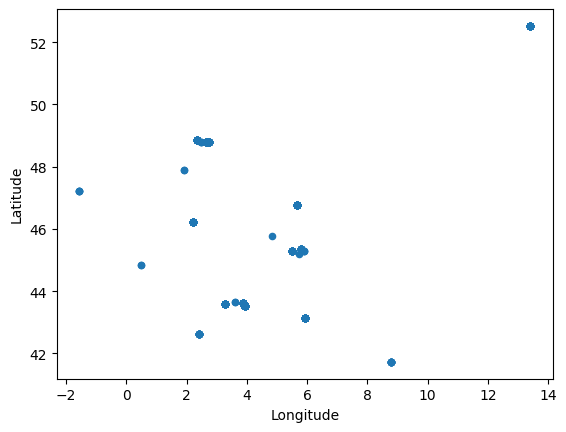

In [7]:
df.plot(kind='scatter', x='Longitude', y='Latitude')

In [8]:
!cat '/kaggle/input/image-classification-for-plants-leaf/Test images/1000.xml'

Our test images have XML that is formatted differently, and it looks like they do not have Taxon blocks.